# Scraping Zonaprops.


La idea es generar un `dataframe` con los siguiente atributos:

| Atributo   | Tipo  | Descripción                             |
|------------|-------|-----------------------------------------|
| `price`    | `float`| Precio de alquiler en ARS              |
| `expenses` | `float`| Precio de expensas en ARS              |
| `location` | `string`| Barrio del inmueble                   |
| `address`  | `string`| Dirección del inmueble                |
| `m2`       | `int`  | Tamaño en $m^2$ del inmueble           |
| `ambients` | `int`  | Número de ambientes                    |
| `baths`    | `int`  | Número de baños                        |
| `bedrooms` | `int`  | Número de dormitorios                  |
| `garage`   | `int`  | Cantidad de cocheras                   |

Se tiene que hacer scraping a varias páginas, son alrededor de 2K inumebles listados.

In [262]:
import undetected_chromedriver as uc
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
import time
import random
import re

## Configuración

In [267]:
# dólar blue
PRECIO_DOLAR = 1300

# N_PAGINAS == número de alquileres listados/30
N_PAGINAS = 63

## Funciones de parsing

In [263]:
def parse_features(features_str):
    """
        Input: string separada por \n
        Output: 
         {
           'tot': int, 
           'amb':int, 
           'dorm':int, 
           'baños':int, 
           'coch':int
          }
    """
    attributes = ['tot', 'amb', 'dorm', 'baños', 'coch']
    feature_dict = {attr: 0 for attr in attributes}
    pattern = re.compile(r'(\d+)\s*([^\n]*)')
    matches = pattern.findall(features_str)
    
    for value, attr in matches:
        for attribute in attributes:
            if attribute in attr:
                feature_dict[attribute] = int(value)
                break
    
    return feature_dict


def parse_price(price_str, exchange_rate=PRECIO_DOLAR):
    """
       Input: string del precio en pesos o en USD
       Output float del precio convertido a pesos 
    """
    if price_str == 'No disponible':
        return None
    
    price_str = price_str.strip()
    
    if price_str.startswith("USD"):
        price_str = price_str[len("USD"):].strip()
        price_value = float(price_str.replace(".", "").replace(",", "."))
        return price_value * exchange_rate
    
    elif price_str.startswith("$"):
        price_str = price_str[len("$"):].strip()
        return float(price_str.replace(".", "").replace(",", "."))
    else:
        return None

def parse_expenses(expenses_str):
    """
       Input: string del precio en pesos o en USD
       Output float del precio convertido a pesos 
    """
    cleaned_str = re.sub(r'[^\d.]', '', expenses_str)
    cleaned_str = cleaned_str.replace('.', '')
    
    try:
        return float(cleaned_str)
    except ValueError:
        return None


## Bot de scraping

In [264]:
def scraping_bot():
    # Configurar las opciones del navegador
    options = Options()
    options.headless = False  # Ejecutar en modo sin cabeza (sin interfaz gráfica)
    # Disable loading images for faster crawling
    options.add_argument('--blink-settings=imagesEnabled=false')

    # Configurar el servicio de ChromeDriver
    service = Service(ChromeDriverManager().install())

    # Inicializar el navegador con undetected_chromedriver
    # Esto es para que Cloudflare no detecte que es un bot.
    driver = uc.Chrome(service=service, options=options)


    data_list = []

    # Recorrer cada página
    for page_number in range(1, N_PAGINAS + 1):
        url = f"https://www.zonaprop.com.ar/departamentos-alquiler-cordoba-cb-pagina-{page_number}.html"
        driver.get(url)

        # Esperar a que la página cargue completamente
        try:
            wait = WebDriverWait(driver, 1)  # Incrementar el tiempo de espera si es necesario

            # Esperar hasta que los elementos con los precios estén presentes
            postings = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div[class="PostingContainer-sc-i1odl-2 iQlPeD"]')))

            for posting in postings:
                try:
                    # Extraer el precio
                    price_element = posting.find_element(By.CSS_SELECTOR, 'div[class="Price-sc-12dh9kl-3 geYYII"]')
                    price = price_element.text
                except NoSuchElementException:
                    price = 'No disponible'

                try:
                    # Extraer expensas
                    expenses_element = posting.find_element(By.CSS_SELECTOR, 'div[class="Expenses-sc-12dh9kl-1 iboaIF"]')
                    expenses = expenses_element.text
                except NoSuchElementException:
                    expenses = 'No disponible'

                try:
                    # Zona
                    location_element = posting.find_element(By.CSS_SELECTOR, 'h2[class="LocationLocation-sc-ge2uzh-2 fziprF"]')
                    location = location_element.text
                except NoSuchElementException:
                    location = 'No disponible'

                try:
                    # Dirección
                    address_element = posting.find_element(By.CSS_SELECTOR, 'div[class="LocationAddress-sc-ge2uzh-0 iylBOA postingAddress"]')
                    address = address_element.text
                except NoSuchElementException:
                    address = 'No disponible'

                try:
                    # Extraer las características
                    features_element = posting.find_element(By.CSS_SELECTOR, 'h3[data-qa="POSTING_CARD_FEATURES"]')
                    features = features_element.text

                except NoSuchElementException:
                    features = 'No disponible'

                features = parse_features(features)

                msquare = features['tot']
                ambients = features['amb']
                bedrooms = features['dorm']
                baths = features['baños']
                garage = features['coch']


                data_list.append({
                        'price': parse_price(price),
                        'expenses': parse_expenses(expenses),
                        'location': location,
                        'address': address,
                        'm2': msquare,
                        'ambients' : ambients,
                        'baths' : baths,
                        'bedrooms': bedrooms,
                        'garage': garage
                    })



        except Exception as e:
            print(f"Error en la página {page_number}: {e}")

        time.sleep(random.uniform(3, 5))

    print(f"Hay {len(data_list)} anuncios extraídos.")
    return data_list


    driver.quit()

## Descomentar esta linea para correr el bot (es lento) 

In [265]:
#data_list = scraping_bot()

## Convertir a un dataframe de pandas.

In [268]:
import pandas as pd
df = pd.DataFrame(data_list)
pd.set_option('display.float_format', lambda x: '{:.1f}'.format(x))
df

""


# Convertir dataframe a .csv y guardarlo

In [259]:
df.to_csv('alquileres_cba_sep.csv', index=False)  

# Sumario de datos agrupados por precios de alquiler barrio

In [266]:
# eliminamos outliers de precios muy altos 
summary = df[(df['price'] < 1500000.0)].groupby('location').describe()
summary = summary[summary['price']['count']>20]

# ordenamos por media del precio
summary_reset = summary.reset_index()
sorted_max_price = summary_reset.sort_values(by=('price','mean'), ascending=False)
sorted_max_price

location price                                               \
                           count     mean      std      min      25%      50%   
5         Córdoba, Córdoba  86.0 393104.7 174030.4   7000.0 260000.0 350000.0   
8   Nueva Córdoba, Córdoba 630.0 378715.5 186128.9    280.0 270000.0 330000.0   
6     General Paz, Córdoba 129.0 359147.3 131795.0  30000.0 270000.0 330000.0   
3          Centro, Córdoba 254.0 317185.0 146693.6  40000.0 220000.0 260000.0   
4          Cofico, Córdoba  68.0 314029.4 120789.2  29000.0 230000.0 275000.0   
7          Güemes, Córdoba  50.0 313500.0 165585.7 180000.0 230000.0 280000.0   
2    Alto Alberdi, Córdoba  66.0 304166.7 155994.5  25000.0 220000.0 260000.0   
1    Alta Córdoba, Córdoba  45.0 295000.0  95946.2 180000.0 220000.0 260000.0   
0         Alberdi, Córdoba 133.0 284364.2 150886.8      1.0 210000.0 250000.0   
9    Observatorio, Córdoba  45.0 281573.3 167792.4    300.0 220000.0 240000.0   
10     San Martín, Córdoba  25.0 267000.0  90011.6 180000.0 200000.0 250000.0   

                      expenses  ... bedrooms      garage                       \
        75%       max    count  ...      75%  max  count mean std min 25% 50%   
5  480000.0  910000.0     65.0  ...      2.0  4.0   86.0  0.2 0.4 0.0 0.0 0.0   
8  450000.0 1430000.0    440.0  ...      2.0 30.0  630.0  0.0 0.2 0.0 0.0 0.0   
6  420000.0  884000.0    100.0  ...      2.0  3.0  129.0  0.1 0.3 0.0 0.0 0.0   
3  370000.0  800000.0    194.0  ...      2.0 12.0  254.0  0.0 0.2 0.0 0.0 0.0   
4  352500.0  650000.0     45.0  ...      1.0  3.0   68.0  0.1 0.3 0.0 0.0 0.0   
7  350000.0 1300000.0     42.0  ...      1.0  3.0   50.0  0.1 0.2 0.0 0.0 0.0   
2  350000.0  950000.0     45.0  ...      1.0  2.0   66.0  0.1 0.3 0.0 0.0 0.0   
1  350000.0  600000.0     35.0  ...      1.0  3.0   45.0  0.1 0.3 0.0 0.0 0.0   
0  330000.0 1430000.0    110.0  ...      1.0  5.0  133.0  0.0 0.2 0.0 0.0 0.0   
9  320000.0  900000.0     33.0  ...      1.0  3.0   45.0  0.0 0.0 0.0 0.0 0.0   
10 300000.0  585000.0     18.0  ...      2.0  3.0   25.0  0.2 0.4 0.0 0.0 0.0   

            
   75% max  
5  0.0 2.0  
8  0.0 2.0  
6  0.0 1.0  
3  0.0 1.0  
4  0.0 1.0  
7  0.0 1.0  
2  0.0 1.0  
1  0.0 1.0  
0  0.0 1.0  
9  0.0 0.0  
10 0.0 1.0  

[11 rows x 57 columns]

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Alquiler 1 dormitorio, sin cochera.

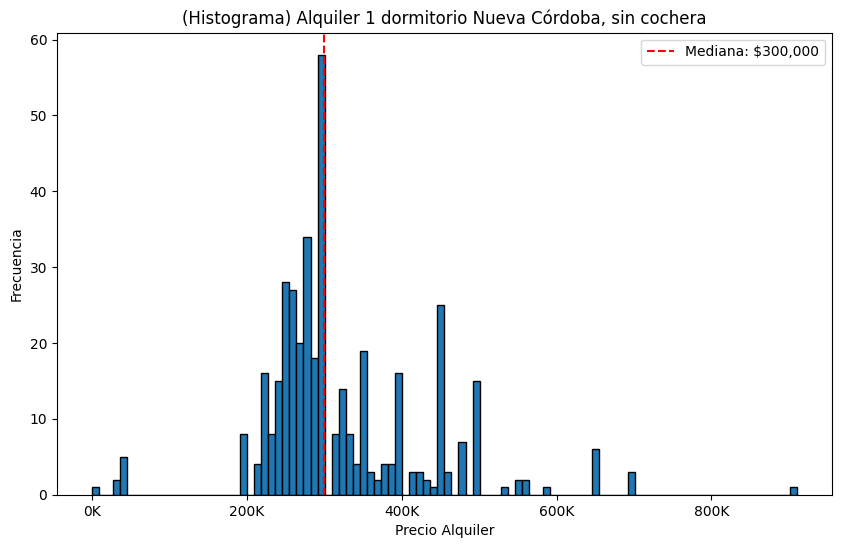

In [258]:
df1=df[(df['price'] < 5000000.0) & (df['location'] == "Nueva Córdoba, Córdoba") & (df['bedrooms'] == 1)& (df['garage'] == 0)]

mean_price = df1['price'].median()

plt.figure(figsize=(10, 6))  
plt.hist(df1['price'], bins=100, edgecolor='black') 

plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1.5, label=f'Mediana: ${mean_price:,.0f}')

plt.title('(Histograma) Alquiler 1 dormitorio Nueva Córdoba, sin cochera')
plt.xlabel('Precio Alquiler')
plt.ylabel('Frecuencia')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))


plt.legend()

plt.grid(False)
plt.show()

# Expensas 1 dormitorio, sin cochera.

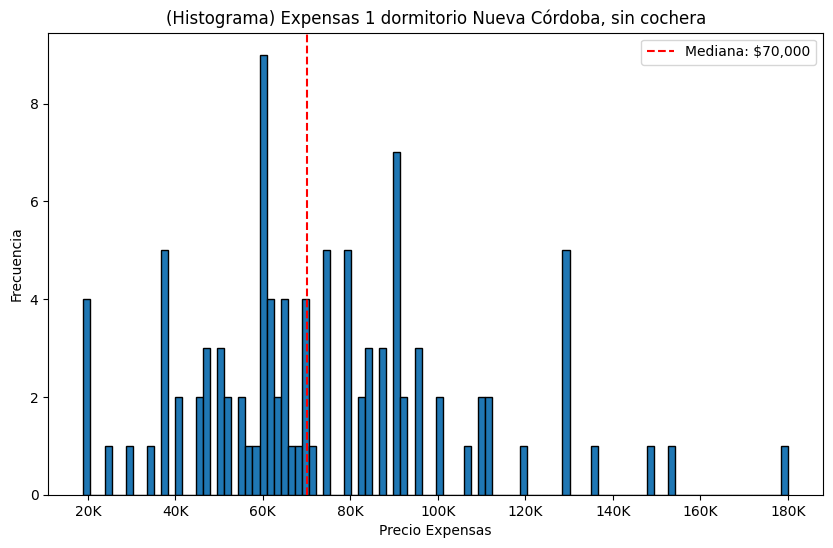

In [198]:
df2=df[(df['price'] < 1000000.0) & (df['location'] == "Nueva Córdoba, Córdoba") & (df['bedrooms'] == 1)& (df['garage'] == 0)]

mean_price = df1['expenses'].median()

plt.figure(figsize=(10, 6))  # Optional: specify the size of the figure
plt.hist(df1['expenses'], bins=100, edgecolor='black')  # You can adjust bins as needed

plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1.5, label=f'Mediana: ${mean_price:,.0f}')

plt.title('(Histograma) Expensas 1 dormitorio Nueva Córdoba, sin cochera')
plt.xlabel('Precio Expensas')
plt.ylabel('Frecuencia')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

plt.legend()

plt.grid(False)
plt.show()

In [194]:
df2['expenses'].describe()

count      276.0
mean     60734.1
std      25110.2
min          1.0
25%      45000.0
50%      60000.0
75%      70250.0
max     160000.0
Name: expenses, dtype: float64

# Alquiler 2 dormitorios, sin cochera.

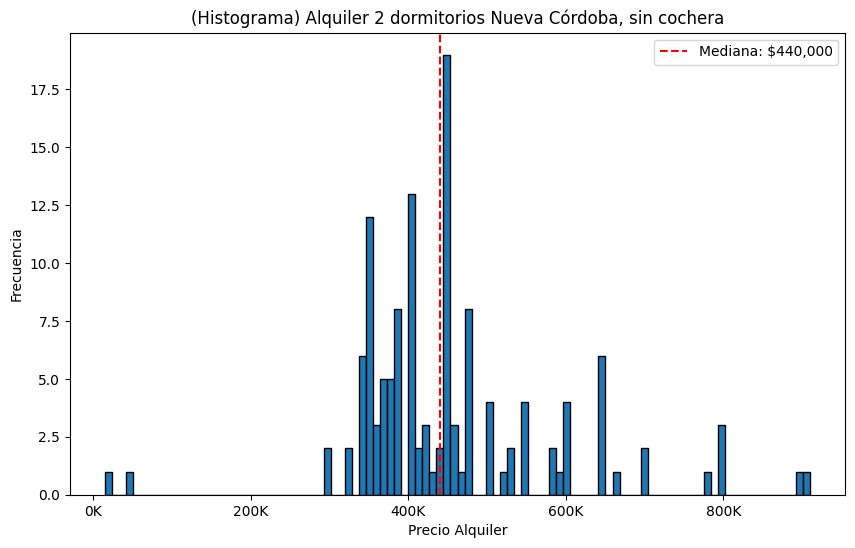

In [195]:
df1=df[(df['price'] < 1000000.0) & (df['location'] == "Nueva Córdoba, Córdoba") & (df['bedrooms'] == 2)& (df['garage'] == 0)]

mean_price = df1['price'].median()

plt.figure(figsize=(10, 6))  
plt.hist(df1['price'], bins=100, edgecolor='black') 

plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1.5, label=f'Mediana: ${mean_price:,.0f}')

plt.title('(Histograma) Alquiler 2 dormitorios Nueva Córdoba, sin cochera')
plt.xlabel('Precio Alquiler')
plt.ylabel('Frecuencia')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))


plt.legend()

plt.grid(False)
plt.show()

# Expensas 2 dormitorios, sin cochera.

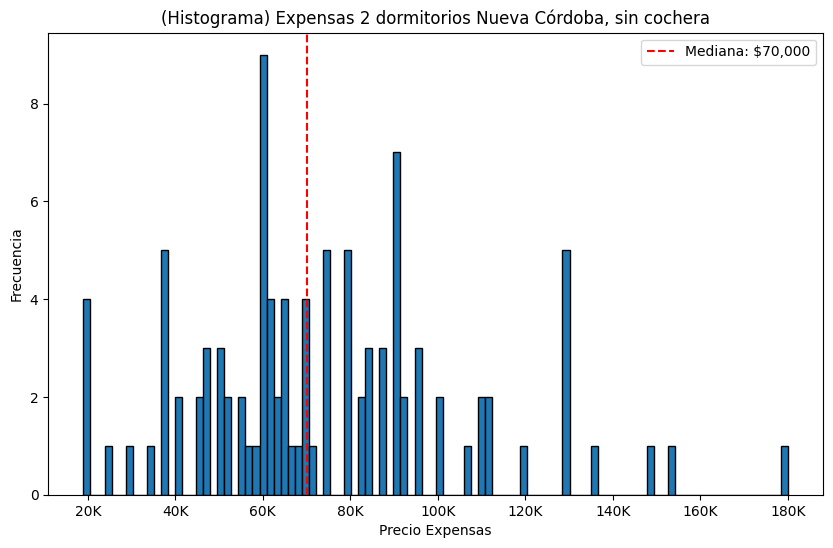

In [196]:
df2=df[(df['price'] < 1000000.0) & (df['location'] == "Nueva Córdoba, Córdoba") & (df['bedrooms'] == 2)& (df['garage'] == 0)]

mean_price = df1['expenses'].median()

plt.figure(figsize=(10, 6))  
plt.hist(df1['expenses'], bins=100, edgecolor='black') 

plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1.5, label=f'Mediana: ${mean_price:,.0f}')

plt.title('(Histograma) Expensas 2 dormitorios Nueva Córdoba, sin cochera')
plt.xlabel('Precio Expensas')
plt.ylabel('Frecuencia')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

plt.legend()

plt.grid(False)
plt.show()